In [1]:
# import library
import pandas
import numpy as np
import math
import matplotlib.pyplot as plt

import pymoo
from pymoo.model.problem import Problem

import pandas as pd


import joblib

In [2]:
# import ML model

date = "0610"

ML_model_Llt = joblib.load(f'leakage_inductance_{date}.pkl')
ML_model_Lmt = joblib.load(f'magnetizing_inductance_{date}.pkl')
ML_model_Rt = joblib.load(f'Rt_{date}.pkl')
ML_model_Rr = joblib.load(f'Rr_{date}.pkl')

In [50]:

# core loss parameter
core_temp = 70

core_a = 0.6942
core_x = 1.4472
core_y = 2.4769
core_b = 4.7948
core_c = 0.0684
core_d = 4e-4
core_LT = core_b - core_c*core_temp + core_d*core_temp**2



# NSAG-II main

popsize = int(100/5)
offsprings = int(3000/5)

one1 = np.ones(offsprings)
one2 = np.ones(popsize)

#N11 = np.concatenate((4*one1,5*one1,6*one1,7*one1,8*one1,9*one1,10*one1,11*one1,12*one1,13*one1), axis=None)
#N12 = np.concatenate((4*one2,5*one2,6*one2,7*one2,8*one2,9*one2,10*one2,11*one2,12*one2,13*one2), axis=None)\

N11 = np.concatenate((8*one1,9*one1,10*one1,11*one1,12*one1), axis=None)
N12 = np.concatenate((8*one2,9*one2,10*one2,11*one2,12*one2), axis=None)

freq = 30e+3

permeability = 3500

b_N1 = [4,12]
b_w1 = [30,200]*5
b_l1 = [10,50]*5
b_l2 = [50,110]
b_h1 = [50,200]
b_space1 = [20,50]
b_space2 = [20,50]
b_space3 = [5,50]
b_space4 = [5,50]
b_coil_width1 = [3,10]
b_coil_width2 = [3,10]
b_move_z1 = [1,5]
b_move_z2 = [1,5]
b_offset_z1 = [-20,20]
b_offset_z2 = [-20,20]


class MyProblem(Problem):
    def __init__(self, ML_model_Llt, ML_model_Lmt, ML_model_Rt, ML_model_Rr):
        super().__init__(n_var=15,     #number of inputs
                         n_obj=2,     #number of outputs
                         n_constr=40,  #nubmer of constraints
                         xl=np.array([b_N1[0],b_w1[0],b_l1[0],b_l2[0],b_h1[0],b_space1[0],b_space2[0],b_space3[0],b_space4[0],
                         b_coil_width1[0],b_coil_width2[0],b_move_z1[0],b_move_z2[0],b_offset_z1[0],b_offset_z2[0]]), #input lower bounds
                         xu=np.array([b_N1[1],b_w1[1],b_l1[1],b_l2[1],b_h1[1],b_space1[1],b_space2[1],b_space3[1],b_space4[1],
                         b_coil_width1[1],b_coil_width2[1],b_move_z1[1],b_move_z2[1],b_offset_z1[1],b_offset_z2[1]])) #input upper bounds
        self.ML_model_Llt = ML_model_Llt
        self.ML_model_Lmt = ML_model_Lmt
        self.ML_model_Rt = ML_model_Rt
        self.ML_model_Rr = ML_model_Rr




# ["N1","w1","l1","l2","h1","space1","space2","space3","space4","coil_width1","coil_width2","move_z1","move_z2","offset_z1","offset_z2","freq","Llt","Llr"]
    def _evaluate(self, X, out, *args, **kwargs):

        

        #try :
        #    X[:,0] = N11
        #except :
        #    X[:,0] = N12

        N1 = X[:,0] 

        X[:,1] = X[:,1] / 5
        X[:,2] = X[:,2] / 5

        w1 = X[:,1] * 1e-3
        l1 = X[:,2] * 1e-3
        l2 = X[:,3] * 1e-3
        h1 = X[:,4] * 1e-3

        space1 = X[:,5] * 1e-3 # 1차 측 w 방향
        space2 = X[:,6] * 1e-3 # 1차 측 l 방향
        space3 = X[:,7] * 1e-3 # 2차 측 w 방향
        space4 = X[:,8] * 1e-3 # 2차 측 l 방향

        coil_width1 = X[:,9] * 1e-3
        coil_width2 = X[:,10] * 1e-3

        move_z1 = X[:,11] * 1e-3
        move_z2 = X[:,12] * 1e-3

        offset_z1 = X[:,13] * 1e-3
        offset_z2 = X[:,14] * 1e-3


        V1 = 1036
        I1 = 100
        I2 = 100

        l = 2*l1 + l2 + space2 + space4 + coil_width1/2 + coil_width2/2
        l_inner = space2 + space4 + coil_width1/2 + coil_width2/2
        h = 2*l1 + h1
        wp = 1*w1 + 2*space1 + coil_width1
        ws = 1*w1 + 2*space3 + coil_width2

        hp = (N1+1)*coil_width1 + N1*move_z1 + 2*abs(offset_z1)
        hs = (N1+1)*coil_width2 + N1*move_z2 + 2*abs(offset_z2)

        
        # Lmt
        f1 = self.ML_model_Lmt.predict( X ) # [unit : mH]
        Lmt = f1 * 1e-6 * permeability/1000 # [unit : H]

        # total volume
        f2 = l * h * wp   # Volume [Unit : m^3]
        f3 = l * h * ws   # Volume [Unit : m^3]

        V = f2

        A = l * wp
        
        V_core = (2*l1+l2)*h*w1 - l2*h*w1 # Core volume [unit : m^3]

        mag_current = V1/(2*3.141592*freq)/Lmt
        Req = N1**2/Lmt
        flux = N1 * mag_current/Req
        B = flux / (2*w1*l1)
        #B = V1 / (2*l1*w1) / (2*3.141592*freq) / N1

        coreloss = core_a * freq**core_x * B**core_y * core_LT * V_core # Core loss [unit : W]
        f4 = coreloss

        f5 = self.ML_model_Rt.predict( X ) * I1**2 # copperloss_tx [unit : W]
        f6 = self.ML_model_Rr.predict( X ) * I2**2 # copperloss_rx [unit : W]

        ########################################################################
        f7 = f4*1 + f5*3 + f6*10 # total loss [unit : W]
        ########################################################################

        f8 = self.ML_model_Llt.predict( X ) # [unit : uH]
        Llt = f8 * 1e-6 # [unit : H]
        #print(np.average(Llt[0]*1e+6))



        #gLlt1 = -(Llt * 1.5 - 16.77e-6) * (Llt * 0.5 - 16.77e-6) / 5e-12 * 10 # Llt constraint
        #gLlt2 = -(Llt * 1.05 - 16.77e-6) * (Llt * 0.95 - 16.77e-6) / 5e-12 * 1 # Llt constraint
        gLlt = -(Llt * 1.02 - 32.375e-6 * 1) * (Llt * 0.98 - 32.375e-6 * 1) / 100e-12 * 10 # Llt constraint
        gLmt = -(Lmt - 500e-6) * (Lmt - 10e-3) / 500e-12
        #print(np.average(gLlt))

        gspace1 = - (space1 - coil_width1 - 20e-3) * (space1 - 50e-3) / 10e-6 # 1차측 w방향
        gspace2 = - (space2 - coil_width1 - 20e-3) * (space2 - 50e-3) / 10e-6 # 1차측 l방향
        gspace3 = - (space3 - coil_width2 - 5e-3) * (space3 - 20e-3) / 10e-6 # 2차측 w방향
        gspace4 = - (space4 - coil_width2 - 5e-3) * (space4 - 20e-3) / 10e-6 # 2차측 l방향
        gspace = -(ws - 0e-3) * (ws - wp) / 1e-6

        gl = -(l-0e-3)*(l-250e-3) / 250e-6
        gl2 = -(l2-l_inner-50e-3)*(l2-500e-3) / 400e-3

        gh = -(h-0e-3)*(h-140e-3) / 160e-6
        ghp = -(h1-hp-15e-3) * (h1 - 400e-3) / 400e-3
        ghs = -(h1-hs-5e-3) * (h1 - 400e-3) / 400e-3


        gwp = -(wp-0e-3)*(wp-180e-3) / 250e-6
        gws = -(ws-0e-3)*(ws-180e-3) / 250e-6

        

        gB = -(B-0)*(B-1.0)

        #gV = -(f2-f3) / 1e-3
        print(np.average(B))
        print(f'min : {np.min(N1)}, max : {np.max(N1)}, avg : {np.average(N1)}')

        
        """
        g1 = g_N1
        g2 = gLlt3
        g1 = gspace1
        g2 = gspace2
        g3 = gspace3
        g4 = gspace4
        g5 = gh11
        g6 = gh12
        g7 = gl
        g8 = gh
        g9 = gw
        g10 = gB
        g11= g_ins1
        g12 = g_ins2
        g13 = g_ins3
        g14 = g_ins4
        g15 = g_air1
        g16 = g_air2
        g17 = g_air3
        g18 = g_air4
        """

        #g_space = [g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18]
        #g_space = [g1.T,g2.T,g3.T,g4.T,g5.T,g6.T,g7.T,g8.T,g9.T,g10.T,g11.T,g12.T,g13.T,g14.T,g15.T,g16.T,g17.T,g18.T]
        #g_space = np.swapaxes(g_space,0,1)
        #g_space = np.where(g_space<0 , 0 , g_space)
        #vec = np.vectorize(math.clamp(X,0))

        #print(g_space[0])


        out["F"] = np.column_stack([V, f7]) # "Minimize" values (volume, coreloss)
        out["G"] = np.column_stack([gLlt, gLmt, gspace1, gspace2, gspace3, gspace4, gspace, gl, gl2, gh, ghp, ghs, gwp, gws, gB])
        
        out["G"] = - out["G"] # Actually < 0 

problem = MyProblem(ML_model_Llt, ML_model_Lmt, ML_model_Rt, ML_model_Rr)


In [51]:
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.operators.mixed_variable_operator import MixedVariableSampling, MixedVariableMutation, MixedVariableCrossover

# ["N1","w1","l1","l2","h1","space1","space2","space3","space4","coil_width1","coil_width2","move_z1","move_z2","offset_z1","offset_z2","freq","Llt","Llr"]
mask = ["int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int"]

algorithm = NSGA2(
    pop_size=100,
    n_offsprings=3000,

    sampling = MixedVariableSampling(mask, {
        "int": get_sampling("int_random")
    }),

    crossover = MixedVariableCrossover(mask, {
        "int": get_crossover("int_sbx", prob=0.3, eta=10)
    }),

    #mutation=get_mutation("real_pm", eta=40),
    mutation = MixedVariableMutation(mask, {
        "int": get_mutation("int_pm", eta=0.01)
    }),

    eliminate_duplicates=True
)

In [52]:
from pymoo.factory import get_termination

termination = get_termination("n_gen", 1000)

In [53]:
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               termination,
               seed=15, #RANDOM SEED
               save_history=False,
               verbose=True)
res

#print("Best solution found: %s" % res.X)
#print("Function value: %s" % res.F)
#print("Constraint violation: %s" % res.CV)

5.059393629143273
min : 4, max : 12, avg : 7.85
n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |     100 |  3.11282E+01 |  7.64612E+03 |       1 |            - |            -
3.759232853142861
min : 4, max : 12, avg : 9.101333333333333
    2 |    3100 |  0.153753725 |  3.96635E+01 |       1 |  1.26964E+03 |        ideal
1.3568070819732343
min : 4, max : 12, avg : 11.572666666666667
    3 |    6100 |  0.043002500 |  1.609500630 |       1 |  6.48797E+02 |        ideal
1.1039491179302119
min : 4, max : 12, avg : 11.814666666666668
    4 |    9100 |  0.024203750 |  0.047080993 |       1 |  2.14913E+02 |        ideal
0.8334075151988404
min : 4, max : 12, avg : 11.821
    5 |   12100 |  0.008715000 |  0.027374569 |       1 |  1.87843E+02 |        ideal
0.8158373990599579
min : 4, max : 12, avg : 11.869
    6 |   15100 | -0.00000E+00 |  0.010755279 |       1 |  7.40452E+01 |        ideal
0.7987072160028795
min : 4, max : 12, avg : 11.82466666666666

937.6972136264367

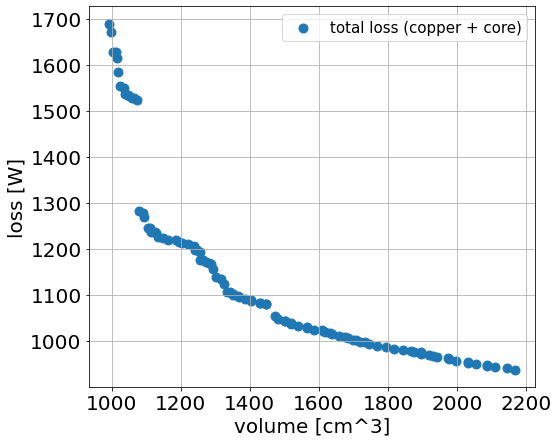

In [36]:
plt.rcParams["figure.figsize"] = (8,7)

parameters = {'xtick.labelsize' : 20,
          'ytick.labelsize' : 20}
plt.rcParams.update(parameters)

plt.scatter(res.F[:,0]*1e+6, res.F[:,1] ,s=80)
plt.xlabel("volume [cm^3]", fontsize=20)
plt.ylabel("loss [W]", fontsize=20)
plt.grid(True)
plt.legend(["total loss (copper + core)"], fontsize=15)

min(res.F[:,1])

In [37]:
res.F[1,0]*1e+6

2166.784

In [38]:
res.X[1]

array([12, 32, 17, 110, 94, 28, 24, 11, 12, 4, 4, 2, 3, -1, 0],
      dtype=object)

In [39]:
res.X[1]

array([12, 32, 17, 110, 94, 28, 24, 11, 12, 4, 4, 2, 3, -1, 0],
      dtype=object)

In [40]:
N1 = res.X[:,0] 

w1 = res.X[:,1] * 1e-3
l1 = res.X[:,2] * 1e-3
l2 = res.X[:,3] * 1e-3
h1 = res.X[:,4] * 1e-3

space1 = res.X[:,5] * 1e-3
space2 = res.X[:,6] * 1e-3
space3 = res.X[:,7] * 1e-3
space4 = res.X[:,8] * 1e-3

coil_width1 = res.X[:,9] * 1e-3
coil_width2 = res.X[:,10] * 1e-3

move_z1 = res.X[:,11] * 1e-3
move_z2 = res.X[:,12] * 1e-3

offset_z1 = res.X[:,13] * 1e-3
offset_z2 = res.X[:,14] * 1e-3

V1 = 1036
I1 = 100
I2 = 100

l = 2*l1 + l2 + space2 + space4 + coil_width1/2 + coil_width2/2
l_inner = space2 + space4 + coil_width1/2 + coil_width2/2
h = 2*l1 + h1
wp = 1*w1 + 2*space1 + coil_width1
ws = 1*w1 + 2*space3 + coil_width2
w = wp

hp = (N1+1)*coil_width1 + N1*move_z1 + 2*abs(offset_z1)
hs = (N1+1)*coil_width2 + N1*move_z2 + 2*abs(offset_z2)


X_column = ["N1","w1","l1","l2","h1","space1","space2","space3","space4","coil_width1","coil_width2","move_z1","move_z2","offset_z1","offset_z2"]
X_data = pd.DataFrame(res.X, columns=X_column)
X_data = X_data.astype(float)
#X_data = pd.to_numeric(X_data)


Lmt = ML_model_Lmt.predict( X_data ) * 1e-3 * permeability / 1000

V = l * h * wp

V_core = (2*l1+l2)*h*w1 - l2*h*w1

mag_current = V1/(2*3.141592*freq)/Lmt
Req = N1**2/Lmt
flux = N1 * mag_current/Req
B = flux / (2*w1*l1)

coreloss = core_a * freq**core_x * B**core_y * core_LT * V_core # Core loss [unit : W]

copperloss_tx = ML_model_Rt.predict( X_data ) * I1**2
copperloss_rx = ML_model_Rr.predict( X_data ) * I2**2

total_loss = coreloss + copperloss_tx + copperloss_rx
copperloss = copperloss_tx + copperloss_rx

Llt = ML_model_Llt.predict( X_data )

In [41]:
np.transpose(np.concatenate([[V*1e+6],[copperloss_tx],[copperloss_rx]],axis=0)).shape

(100, 3)

In [56]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

result_data = pd.concat([X_data,pd.DataFrame(np.transpose(np.concatenate([[V*1e+6],[B],[Lmt],[Llt],[w*1e+3],[l*1e+3],[h*1e+3],[total_loss],[copperloss_tx],[copperloss_rx],[copperloss],[coreloss]],axis=0)),columns=["V","B","Lmt","Llt","w","l","h","total_loss","copperloss_tx","copperloss_rx","copperloss","coreloss"])], axis=1)

result_data = result_data.sort_values('V', ascending=True) # 정렬

result_data = result_data[result_data["V"]>1500]


result_data

,N1,w1,l1,l2,h1,space1,space2,space3,space4,coil_width1,coil_width2,move_z1,move_z2,offset_z1,offset_z2,V,B,Lmt,Llt,w,l,h,total_loss,copperloss_tx,copperloss_rx,copperloss,coreloss
67,12.0,31.0,13.0,90.0,94.0,24.0,23.0,11.0,10.0,3.0,4.0,1.0,3.0,12.0,0.0,1500.6,0.568254,0.604873,31.977466,82.0,152.5,120.0,278.831778,123.046224,57.593322,180.639546,98.192232
80,12.0,30.0,13.0,92.0,94.0,24.0,23.0,11.0,10.0,3.0,4.0,1.0,3.0,12.0,0.0,1501.74,0.587196,0.60006,31.897931,81.0,154.5,120.0,283.549336,123.670024,56.814874,180.484899,103.064438
77,12.0,32.0,13.0,90.0,94.0,24.0,23.0,11.0,10.0,3.0,4.0,1.0,3.0,12.0,0.0,1518.9,0.550496,0.604873,31.977466,83.0,152.5,120.0,274.333855,123.046224,57.593322,180.639546,93.69431
66,12.0,31.0,13.0,92.0,94.0,24.0,23.0,11.0,10.0,3.0,4.0,1.0,3.0,12.0,0.0,1520.28,0.568254,0.60006,31.897931,82.0,154.5,120.0,278.677131,123.670024,56.814874,180.484899,98.192232
23,12.0,32.0,13.0,92.0,94.0,24.0,23.0,11.0,10.0,3.0,4.0,1.0,3.0,12.0,0.0,1538.82,0.550496,0.60006,31.897931,83.0,154.5,120.0,274.179208,123.670024,56.814874,180.484899,93.69431
54,12.0,32.0,14.0,90.0,94.0,24.0,23.0,11.0,10.0,3.0,4.0,1.0,3.0,12.0,0.0,1564.467,0.511175,0.604873,31.977466,83.0,154.5,122.0,266.019957,123.046224,57.593322,180.639546,85.380411
62,12.0,31.0,14.0,92.0,94.0,24.0,23.0,11.0,10.0,3.0,4.0,1.0,3.0,12.0,0.0,1565.626,0.527664,0.60006,31.897931,82.0,156.5,122.0,269.964112,123.670024,56.814874,180.484899,89.479214
26,12.0,32.0,14.0,92.0,94.0,24.0,23.0,11.0,10.0,3.0,4.0,1.0,3.0,12.0,0.0,1584.719,0.511175,0.60006,31.897931,83.0,156.5,122.0,265.86531,123.670024,56.814874,180.484899,85.380411
71,12.0,32.0,13.0,101.0,94.0,23.0,23.0,11.0,12.0,3.0,4.0,1.0,3.0,14.0,0.0,1608.66,0.550496,0.592756,31.843598,81.0,165.5,120.0,272.61783,122.716619,56.206902,178.92352,93.69431
99,12.0,31.0,15.0,92.0,94.0,24.0,23.0,11.0,10.0,3.0,4.0,1.0,3.0,12.0,0.0,1611.628,0.492487,0.60006,31.897931,82.0,158.5,124.0,262.620479,123.670024,56.814874,180.484899,82.13558


In [43]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 10)

gLlt = -(Llt * 1.02 - 32.375e-6 * 1) * (Llt * 0.98 - 32.375e-6) / 100e-12 * 1 * 10 # Llt constraint
gLmt = -(Lmt - 500e-6) * (Lmt - 10e-3) / 500e-12
#print(np.average(gLlt))

gspace1 = - (space1 - coil_width1 - 20e-3) * (space1 - 50e-3) / 10e-6 # 1차측 w방향
gspace2 = - (space2 - coil_width1 - 20e-3) * (space2 - 50e-3) / 10e-6 # 1차측 l방향
gspace3 = - (space3 - coil_width2 - 5e-3) * (space3 - 20e-3) / 10e-6 # 2차측 w방향
gspace4 = - (space4 - coil_width2 - 5e-3) * (space4 - 20e-3) / 10e-6 # 2차측 l방향
gspace = -(ws - 0e-3) * (ws - wp) / 1e-6

gl = -(l-0e-3)*(l-250e-3) / 250e-6
gl2 = -(l2-l_inner-50e-3)*(l2-500e-3) / 400e-3

gh = -(h-0e-3)*(h-140e-3) / 160e-6
ghp = -(h1-hp-10e-3) * (h1 - 400e-3) / 400e-3
ghs = -(h1-hs-10e-3) * (h1 - 400e-3) / 400e-3


gwp = -(wp-0e-3)*(wp-180e-3) / 250e-6
gws = -(ws-0e-3)*(ws-180e-3) / 250e-6

gB = -(B-0)*(B-1.0)


g_column = ["gLlt","gLmt","gspace1","gspace2","gspace3","gspace4","gspace","gl","gl2","gh","ghp","ghs","gwp","gws","gB"]
g_data = np.transpose(np.concatenate([[gLlt],[gLmt],[gspace1],[gspace2],[gspace3],[gspace4],[gspace],[gl],[gl2],[gh],[ghp],[ghs],[gwp],[gws],[gB]],axis=0))
g_data = pd.DataFrame(g_data, columns=g_column)

#g_column = ["gLlt","gLmt","gspace1","gspace2","gspace3","gspace4","gspace","gl","gl2","gh","ghp","ghs","gwp","gws"]
#g_data = [[gLlt,gLmt,gspace1,gspace2,gspace3,gspace4,gspace,gl,gl2,gh,ghp,ghs,gwp,gws]]
#g_data = pd.DataFrame(g_data, columns=g_column)

g_data

,gLlt,gLmt,gspace1,gspace2,gspace3,gspace4,gspace,gl,gl2,gh,ghp,ghs,gwp,gws,gB
0,-102576581571236.8125,-505215761.474256,0.0,0.0,-0.0,0.0,438.0,60.736,0.00816,29.025,0.004175,0.000835,31.916,31.244,0.180644
1,-100821865284041.890625,-634486618.784705,8.8,0.0,1.8,2.4,1972.0,48.576,0.0195,9.6,0.00459,-0.00306,32.384,28.304,0.243754
2,-101529228844582.3125,-598562517.874398,2.6,0.0,2.7,0.0,1508.0,60.736,0.00816,28.6,0.00581,-0.00415,32.256,28.304,0.21238
3,-100860014568348.359375,-665266014.654451,0.0,0.0,2.7,2.0,1368.0,59.136,0.01206,29.025,0.004175,0.000835,32.076,28.044,0.203497
4,-101440492235878.671875,-577331492.978392,0.0,0.0,-0.0,0.0,438.0,60.564,0.009157,29.025,0.004175,0.000835,31.916,31.244,0.180644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-101412960534861.953125,-1270626020.431619,2.6,2.6,1.1,0.0,1620.0,56.1,0.01881,28.125,0.00588,-0.00336,32.256,27.216,0.24322
96,-100860014568348.359375,-665266014.654451,0.0,0.0,2.7,2.0,1344.0,59.136,0.01206,29.025,0.004175,0.000835,32.0,27.776,0.193008
97,-100830761977800.28125,-511359298.186387,2.6,2.6,1.1,2.0,1530.0,58.144,0.013965,28.6,0.00581,-0.00415,32.076,26.316,0.180644
98,-103126750175888.71875,-920207017.325274,2.6,0.0,1.8,1.0,1425.0,59.475,0.003587,21.6,0.003975,-0.00318,32.144,28.044,0.245341


937.6972136264367

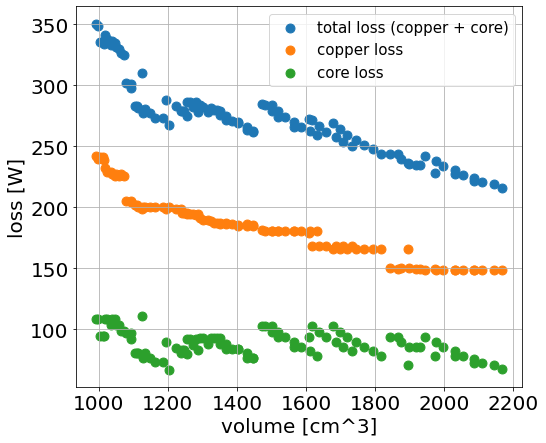

In [44]:
plt.rcParams["figure.figsize"] = (8,7)

parameters = {'xtick.labelsize' : 20,
          'ytick.labelsize' : 20}
plt.rcParams.update(parameters)

plt.scatter(V*1e+6, total_loss ,s=80)
plt.scatter(V*1e+6, copperloss ,s=80)
plt.scatter(V*1e+6, coreloss ,s=80)
plt.xlabel("volume [cm^3]", fontsize=20)
plt.ylabel("loss [W]", fontsize=20)
plt.grid(True)
plt.legend(["total loss (copper + core)","copper loss","core loss"], fontsize=15)

min(res.F[:,1])

937.6972136264367

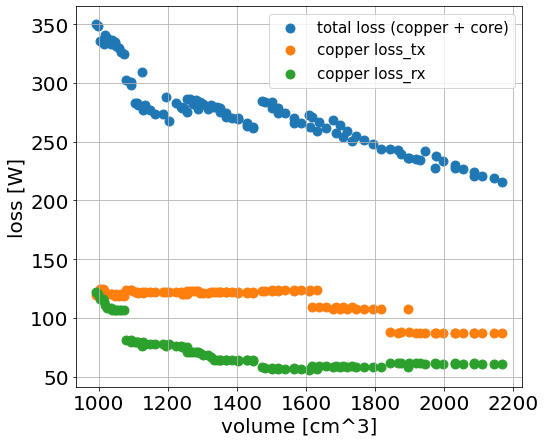

In [45]:
plt.rcParams["figure.figsize"] = (8,7)

parameters = {'xtick.labelsize' : 20,
          'ytick.labelsize' : 20}
plt.rcParams.update(parameters)

plt.scatter(V*1e+6, total_loss ,s=80)
plt.scatter(V*1e+6, copperloss_tx ,s=80)
plt.scatter(V*1e+6, copperloss_rx ,s=80)
plt.xlabel("volume [cm^3]", fontsize=20)
plt.ylabel("loss [W]", fontsize=20)
plt.grid(True)
plt.legend(["total loss (copper + core)","copper loss_tx","copper loss_rx"], fontsize=15)

min(res.F[:,1])

937.6972136264367

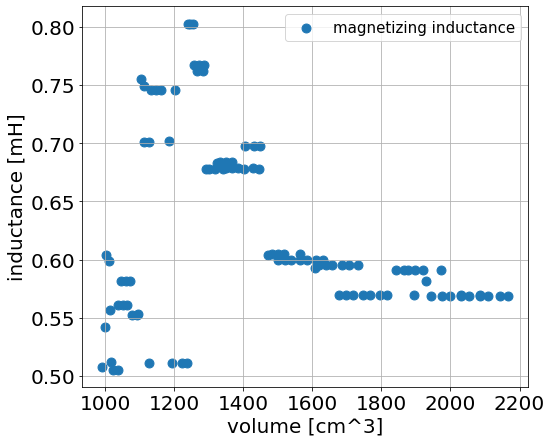

In [46]:
plt.rcParams["figure.figsize"] = (8,7)

parameters = {'xtick.labelsize' : 20,
          'ytick.labelsize' : 20}
plt.rcParams.update(parameters)

plt.scatter(V*1e+6, Lmt ,s=80)
plt.xlabel("volume [cm^3]", fontsize=20)
plt.ylabel("inductance [mH]", fontsize=20)
plt.grid(True)
plt.legend(["magnetizing inductance"], fontsize=15)

min(res.F[:,1])

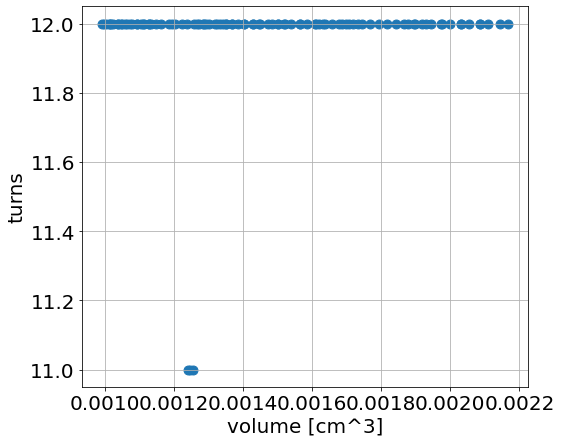

In [47]:
plt.rcParams["figure.figsize"] = (8,7)

parameters = {'xtick.labelsize' : 20,
          'ytick.labelsize' : 20}
plt.rcParams.update(parameters)

plt.scatter(V, N1 ,s=80)
plt.xlabel("volume [cm^3]", fontsize=20)
plt.ylabel("turns", fontsize=20)
plt.grid(True)
#plt.legend(["turns"], fontsize=15)
